<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Models2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [44]:
dataset_60 = load_dataset("anastasiafrosted/globus_60", download_mode="force_redownload")
dataset_300 = load_dataset("anastasiafrosted/globus_300", download_mode="force_redownload")
dataset_3600 = load_dataset("anastasiafrosted/globus_3600", download_mode="force_redownload")
dataset_86400 = load_dataset("anastasiafrosted/globus_86400", download_mode="force_redownload")

df_60 = pd.DataFrame(dataset_60['train'])
df_300 = pd.DataFrame(dataset_300['train'])
df_3600 = pd.DataFrame(dataset_3600['train'])
df_86400 = pd.DataFrame(dataset_86400['train'])

# Ensure the `timestamp` column is in datetime format
df_60['timestamp'] = pd.to_datetime(df_60['timestamp'])
df_300['timestamp'] = pd.to_datetime(df_300['timestamp'])
df_3600['timestamp'] = pd.to_datetime(df_3600['timestamp'])
df_86400['timestamp'] = pd.to_datetime(df_86400['timestamp'])

train-00000-of-00001.parquet:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/176523 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/37667 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/181k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3553 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/178 [00:00<?, ? examples/s]

In [45]:
data = df_86400
data = data.set_index("timestamp")
#data.head()

In [46]:
train_data = data["2022-12-20":"2023-06-01"]
valid_data = data["2023-06-02":"2023-07-01"]
test_data = data["2023-07-01":]

#### Scaling

In [47]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

# Per il dataset di training
scaled_train = train_data.copy()
scaled_train[scaled_train.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data[train_data.columns.drop('avg_invocations_rate')]
)
train = scaled_train

# Per il dataset di validazione
scaled_valid = valid_data.copy()
scaled_valid[scaled_valid.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data[valid_data.columns.drop('avg_invocations_rate')]
)
valid = scaled_valid

# Per il dataset di test
scaled_test = test_data.copy()
scaled_test[scaled_test.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data[test_data.columns.drop('avg_invocations_rate')]
)
test = scaled_test

#### Config (Parameters)

In [48]:
batch_size = 32
num_features = 12
sequence_lenght = 7
prediction_lenght = 7
seed = 42

# Models

## Forecasting one-step-ahead

In [49]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=5):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [50]:
tr = train['avg_invocations_rate']
vl = valid['avg_invocations_rate']

In [51]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    tr.to_numpy(),
    targets=tr[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    vl.to_numpy(),
    targets=vl[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [52]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0026 - mae: 0.0513 - val_loss: 0.0019 - val_mae: 0.0522
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - mae: 0.0475 - val_loss: 0.0017 - val_mae: 0.0491
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0016 - mae: 0.0425 - val_loss: 0.0016 - val_mae: 0.0477
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0019 - mae: 0.0440 - val_loss: 0.0015 - val_mae: 0.0466
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0018 - mae: 0.0434 - val_loss: 0.0015 - val_mae: 0.0459
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.0015 - mae: 0.0459


45920.13359069824

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [54]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(batch_size, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
fit_and_evaluate(univar_model, train_ds, valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - loss: 0.0122 - mae: 0.1315 - val_loss: 0.0043 - val_mae: 0.0821
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0094 - mae: 0.1165 - val_loss: 0.0044 - val_mae: 0.0827
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0056 - mae: 0.0830 - val_loss: 0.0016 - val_mae: 0.0444
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0040 - mae: 0.0718 - val_loss: 0.0010 - val_mae: 0.0404
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0033 - mae: 0.0656 - val_loss: 0.0039 - val_mae: 0.0768
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0010 - mae: 0.0404


40357.11660981178

#### Deep RNN

In [56]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(16),
    tf.keras.layers.Dense(1)
])

In [57]:
fit_and_evaluate(deep_model, train_ds, valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 564ms/step - loss: 0.0247 - mae: 0.1810 - val_loss: 0.0115 - val_mae: 0.1354
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0105 - mae: 0.1210 - val_loss: 0.0129 - val_mae: 0.1494
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0091 - mae: 0.1139 - val_loss: 0.0067 - val_mae: 0.1033
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0053 - mae: 0.0791 - val_loss: 0.0043 - val_mae: 0.0803
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0033 - mae: 0.0647 - val_loss: 0.0019 - val_mae: 0.0508
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0019 - mae: 0.0508


50791.22260212898

### Multivariate Series

In [58]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=train['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=valid['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [59]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(batch_size, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 0.1317 - mae: 0.3742 - val_loss: 0.0477 - val_mae: 0.2492
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0886 - mae: 0.3016 - val_loss: 0.0267 - val_mae: 0.1829
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0586 - mae: 0.2242 - val_loss: 0.0189 - val_mae: 0.1544
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0296 - mae: 0.1564 - val_loss: 0.0175 - val_mae: 0.1489
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0319 - mae: 0.1639 - val_loss: 0.0181 - val_mae: 0.1541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0175 - mae: 0.1489


148942.2172307968

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

In [61]:
X = vl.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


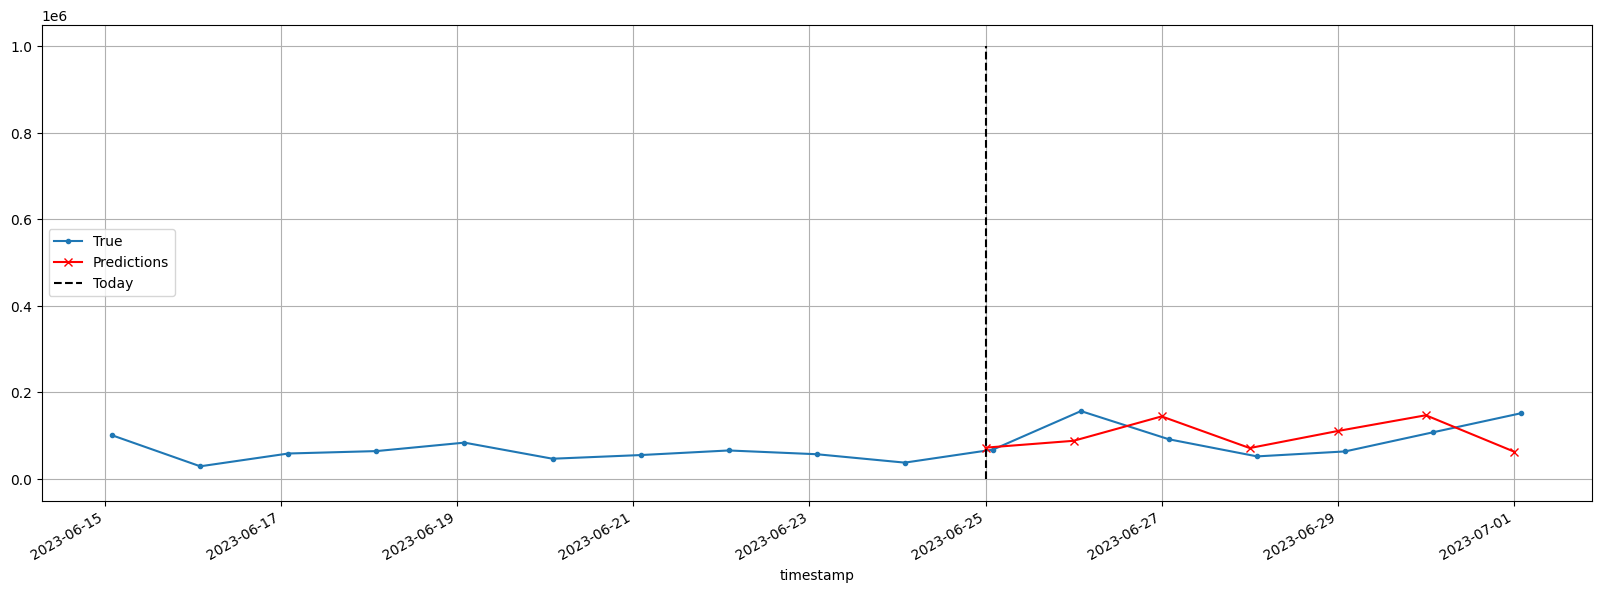

In [62]:
# The forecasts start on 2023-06-01, and they end
# on 2019-06-14. That's 14 days in total.
origin = "2023-06-15"
start = "2023-06-25"
end = "2023-07-01"

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, 0, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [63]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

In [64]:
print(len(ahead_train_ds))  # Check the size of your training dataset
print(len(ahead_valid_ds))  # Check the size of your validation dataset

5
1


#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [65]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(batch_size, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.4942 - mae: 0.8626 - val_loss: 0.3562 - val_mae: 0.7359
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4493 - mae: 0.8110 - val_loss: 0.3178 - val_mae: 0.6961
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4071 - mae: 0.7621 - val_loss: 0.2854 - val_mae: 0.6576
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3742 - mae: 0.7151 - val_loss: 0.2653 - val_mae: 0.6275
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4135 - mae: 0.7609 - val_loss: 0.2531 - val_mae: 0.6077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2531 - mae: 0.6077


607739.8061752319

In [67]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X) # shape [1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


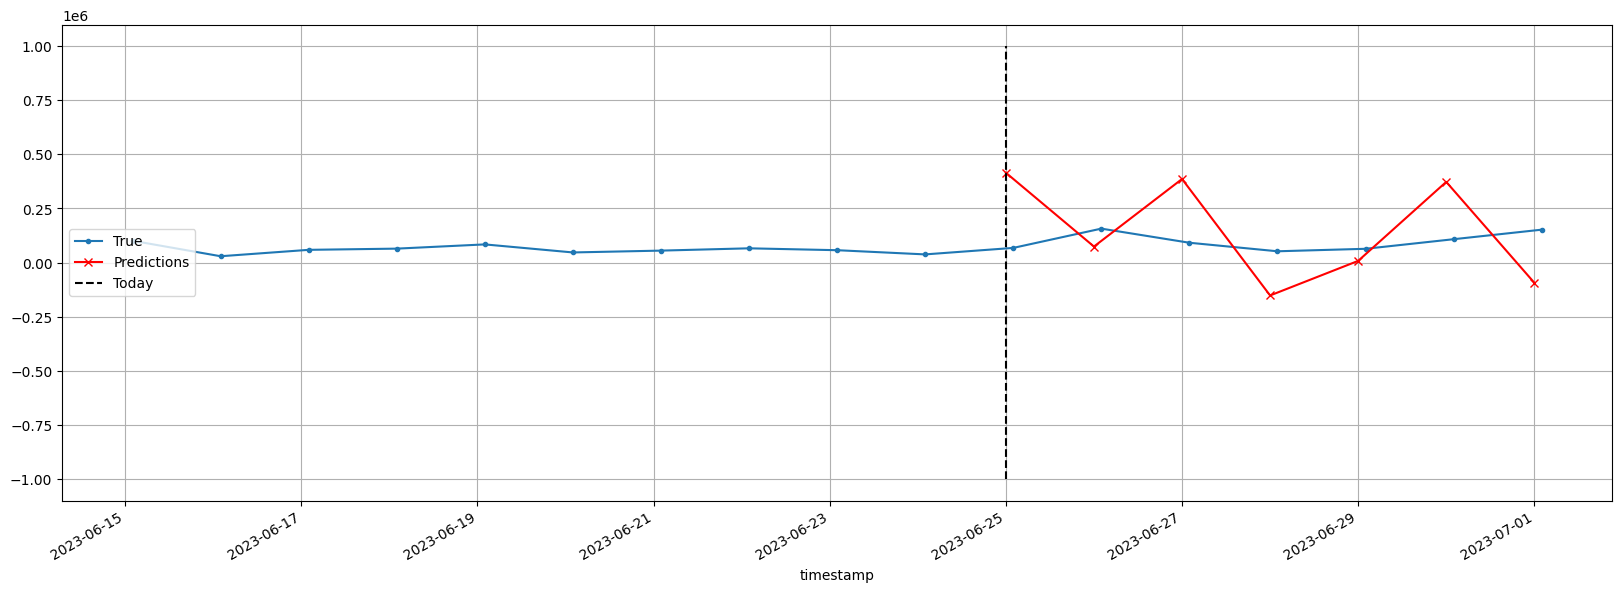

In [68]:
origin = "2023-06-15"
start = "2023-06-25"
end = "2023-07-01"

Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [69]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [70]:
seq2seq_train = to_seq2seq_dataset(train, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

It is almost identical to our previous model: the only difference is that we set
return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 'batch_size'), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 'batch_size'-dimensional
vector as input and outputting a 'prediction_lenght'-dimensional vector.

In [71]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(batch_size, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [72]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid)

Epoch 1/5
      1/Unknown 1s 1s/step - loss: 0.5430 - mae: 0.9047

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.4994 - mae: 0.8611 - val_loss: 0.3448 - val_mae: 0.7165
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5121 - mae: 0.8749 - val_loss: 0.3252 - val_mae: 0.6941
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4443 - mae: 0.7993 - val_loss: 0.3043 - val_mae: 0.6686
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4165 - mae: 0.7632 - val_loss: 0.2880 - val_mae: 0.6470
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4069 - mae: 0.7479 - val_loss: 0.2756 - val_mae: 0.6314
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2756 - mae: 0.6314


631434.1425895691

In [73]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Perchè sembra migliorare? dovrebbe peggiorare (?)

In [74]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=valid.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - valid["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
MAE for +1: 486,662
MAE for +2: 250,951
MAE for +3: 167,864
MAE for +4: 255,337
MAE for +5: 342,533
MAE for +6: 366,832
MAE for +7: 308,772


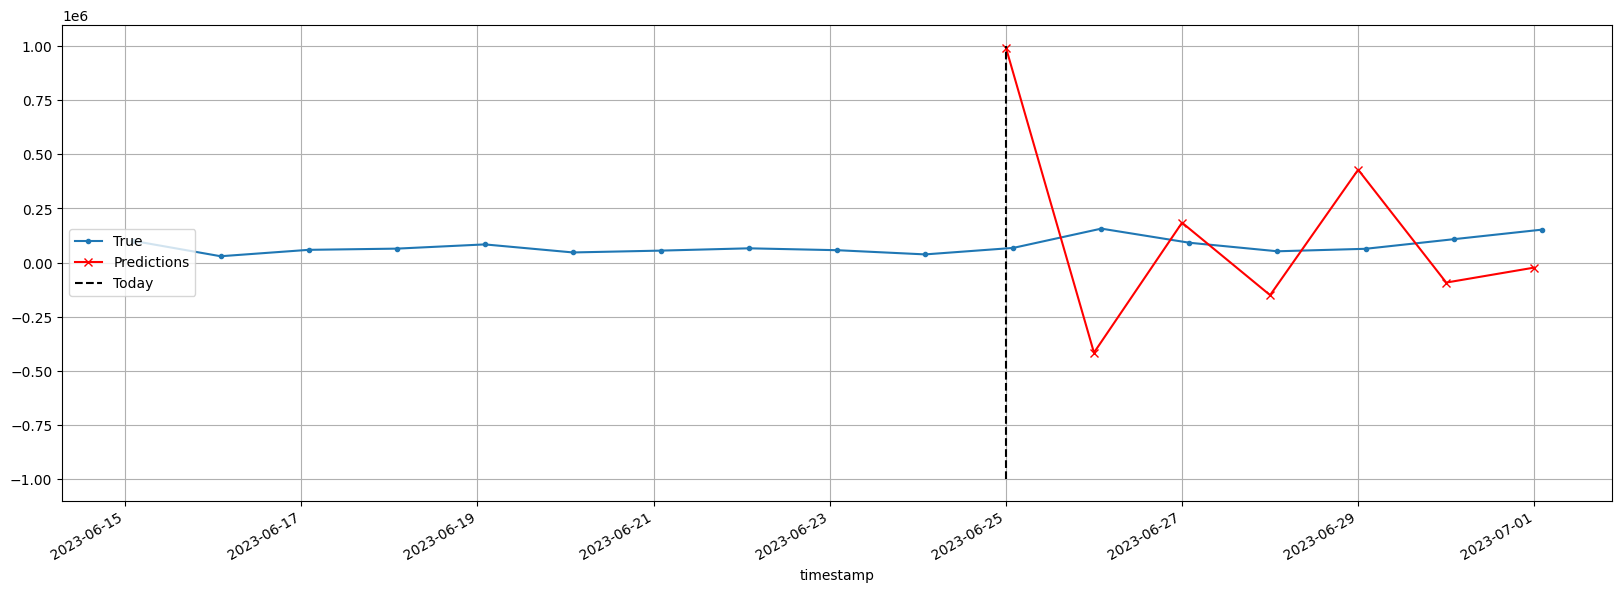

In [75]:
# The forecasts start on 2023-06-01, and they end
# on 2019-06-14. That's 14 days in total.
origin = "2023-06-15"
start = "2023-06-25"
end = "2023-07-01"

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### RNN with layer normalization

In [76]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [77]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(batch_size), return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [78]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid)

Epoch 1/5
      1/Unknown 3s 3s/step - loss: 0.7298 - mae: 1.1240

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.6506 - mae: 1.0442 - val_loss: 0.4242 - val_mae: 0.8053
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5811 - mae: 0.9693 - val_loss: 0.3770 - val_mae: 0.7495
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5343 - mae: 0.9121 - val_loss: 0.3358 - val_mae: 0.6986
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4951 - mae: 0.8659 - val_loss: 0.3057 - val_mae: 0.6612
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4716 - mae: 0.8368 - val_loss: 0.2827 - val_mae: 0.6326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2827 - mae: 0.6326


632550.9548187256

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


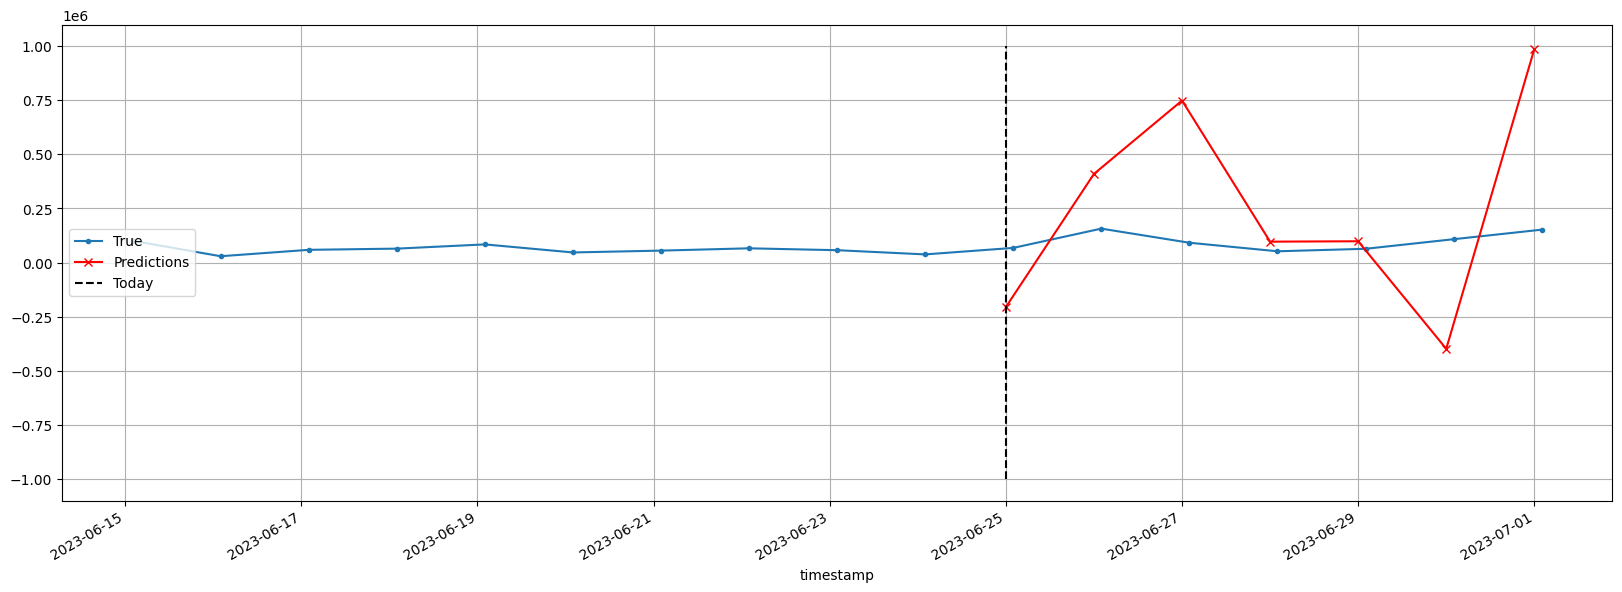

In [79]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

# The forecasts start on 2023-06-01, and they end
# on 2019-06-14. That's 14 days in total.
origin = "2023-06-15"
start = "2023-06-25"
end = "2023-07-01"

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 #### LSTM

In [80]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(batch_size, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [81]:
fit_and_evaluate(lstm, seq2seq_train, seq2seq_valid)

Epoch 1/5
      1/Unknown 2s 2s/step - loss: 0.3687 - mae: 0.7218

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.3622 - mae: 0.7200 - val_loss: 0.2624 - val_mae: 0.6641
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4058 - mae: 0.7634 - val_loss: 0.2591 - val_mae: 0.6590
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3580 - mae: 0.7142 - val_loss: 0.2552 - val_mae: 0.6529
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3806 - mae: 0.7322 - val_loss: 0.2506 - val_mae: 0.6455
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3699 - mae: 0.7180 - val_loss: 0.2465 - val_mae: 0.6383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2465 - mae: 0.6383


638270.4973220825

In [82]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


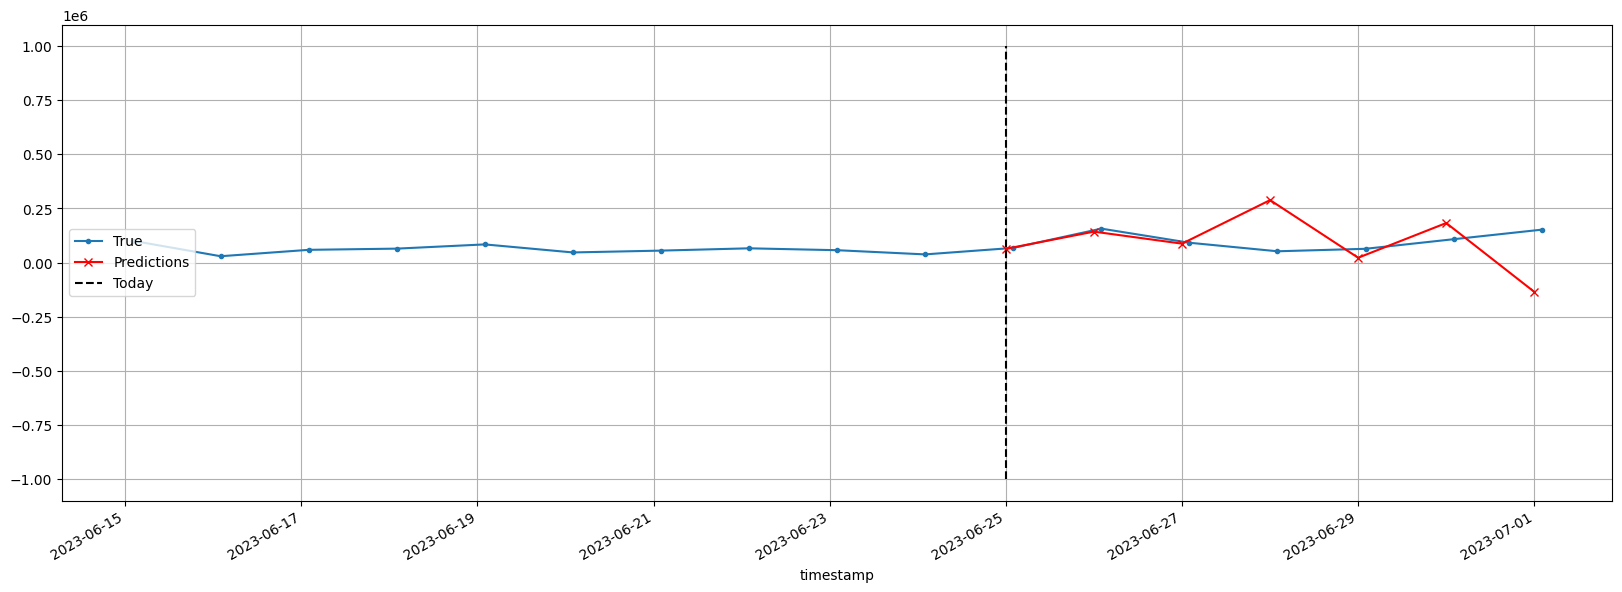

In [83]:
# The forecasts start on 2023-06-01, and they end
# on 2019-06-14. That's 14 days in total.
origin = "2023-06-15"
start = "2023-06-25"
end = "2023-07-01"

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()